In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

c:\Users\ASUS.LAPTOP-A525HU97\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\ASUS.LAPTOP-A525HU97\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\ASUS.LAPTOP-A525HU97\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runt

In [2]:
input_combinations = {
    "Open": ["Open"],
    "Open_High": ["Open", "High"],
    "Open_High_Low": ["Open", "High", "Low"],
    "Open_High_Low_Volume": ["Open", "High", "Low", "Volume"]
}

# ACES

In [9]:
n_steps = 60
ACES = pd.read_csv('../Data/Saham/ACES.csv',parse_dates=['Date'])
ACES = ACES.sort_values('Date').reset_index(drop=True)



In [10]:
ACES

,Date,Close,High,Low,Open,Volume
0,2015-03-02,652.684875,668.412222,644.821202,668.412222,23352800
1,2015-03-03,648.753052,660.548562,644.821215,648.753052,10343800
2,2015-03-04,648.753052,652.684888,640.889378,652.684888,14121100
3,2015-03-05,648.753052,656.616725,644.821215,648.753052,9093500
4,2015-03-06,648.753052,656.616725,644.821215,648.753052,5632200
...,...,...,...,...,...,...
2468,2025-02-24,740.000000,770.000000,730.000000,765.000000,27400200
2469,2025-02-25,700.000000,750.000000,690.000000,745.000000,40993800
2470,2025-02-26,695.000000,715.000000,675.000000,700.000000,32354000
2471,2025-02-27,700.000000,715.000000,695.000000,695.000000,31872200


In [11]:
results = []
histories = {}

# Misal data ACES sudah tersedia di variabel ACES
for comb_name, features in input_combinations.items():
    data = ACES[features].values
    if len(data) < 2 * n_steps:
        continue
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    X, y = [], []
    total_len = len(scaled)
    for i in range(total_len - 2 * n_steps + 1):
        X.append(scaled[i : i + n_steps])
        y.append(scaled[i + n_steps : i + 2 * n_steps, 0])
    X = np.array(X)
    y = np.array(y)
    if len(X) == 0:
        continue
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    model = Sequential()
    model.add(LSTM(50, activation="relu", input_shape=(n_steps, len(features))))
    model.add(Dense(n_steps))
    model.compile(optimizer="adam", loss="mse")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        verbose=0,
        validation_split=0.2
    )
    histories[comb_name] = {
        "loss": history.history['loss'],
        "val_loss": history.history['val_loss']
    }
    y_pred = model.predict(X_test)
    min_close, max_close = scaler.data_min_[0], scaler.data_max_[0]
    y_test_orig = y_test * (max_close - min_close) + min_close
    y_pred_orig = y_pred * (max_close - min_close) + min_close

    # Simpan hasil prediksi dan target untuk cell berikutnya
    globals()[f"y_pred_orig_{comb_name}"] = y_pred_orig
    globals()[f"y_test_orig_{comb_name}"] = y_test_orig

    # Simpan metrik sebelum Kalman Filter
    rmse = np.sqrt(np.mean((y_test_orig - y_pred_orig) ** 2))
    r2 = r2_score(y_test_orig.flatten(), y_pred_orig.flatten())
    results.append([comb_name, rmse, r2])

# Simpan hasil metrik awal ke DataFrame
results_df = pd.DataFrame(results, columns=["kombinasi_input", "RMSE", "R2"])

c:\Users\ASUS.LAPTOP-A525HU97\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


c:\Users\ASUS.LAPTOP-A525HU97\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


c:\Users\ASUS.LAPTOP-A525HU97\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


c:\Users\ASUS.LAPTOP-A525HU97\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [12]:
class KalmanFilter:
    def __init__(self, F, B, H, Q, R, x0, P0):
        self.F = F
        self.B = B
        self.H = H
        self.Q = Q
        self.R = R
        self.x = x0
        self.P = P0

    def predict(self, u):
        self.x = self.F @ self.x + self.B @ u
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, z):
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(self.P.shape[0]) - K @ self.H) @ self.P
        return self.x

F = np.array([[1, 1],
              [0, 1]])
B = np.array([[0],
              [0]])
H = np.array([[1, 0]])
Q = np.array([[1, 0],
              [0, 1]])
R = np.array([[100]])

kalman_results = []

for comb_name in input_combinations.keys():
    y_pred_orig = globals()[f"y_pred_orig_{comb_name}"]
    y_test_orig = globals()[f"y_test_orig_{comb_name}"]

    rmse_filtered_list = []
    r2_filtered_list = []

    for i in range(y_pred_orig.shape[0]):
        x0 = np.array([[y_pred_orig[i, 0]], [0]])
        P0 = np.eye(2)
        kf = KalmanFilter(F, B, H, Q, R, x0, P0)

        smoothed_preds = []
        for z in y_pred_orig[i]:
            z = np.array([[z]])
            u = np.array([[0]])
            kf.predict(u)
            x_filtered = kf.update(z)
            smoothed_preds.append(x_filtered[0, 0])
        smoothed_preds = np.array(smoothed_preds)

        rmse_f = np.sqrt(np.mean((y_test_orig[i] - smoothed_preds) ** 2))
        r2_f = r2_score(y_test_orig[i], smoothed_preds)
        rmse_filtered_list.append(rmse_f)
        r2_filtered_list.append(r2_f)

    rmse_filtered = np.mean(rmse_filtered_list)
    r2_filtered = np.mean(r2_filtered_list)
    kalman_results.append([comb_name, rmse_filtered, r2_filtered])


In [13]:
# Simpan hasil metrik awal ke DataFrame
results_df = pd.DataFrame(results, columns=["kombinasi_input", "RMSE", "R2"])
results_df

,kombinasi_input,RMSE,R2
0,Open,95.168985,0.546718
1,Open_High,90.601513,0.589183
2,Open_High_Low,101.256987,0.486870
3,Open_High_Low_Volume,523.556228,-12.718412


In [14]:
df_kalman_results = pd.DataFrame(kalman_results, columns=["kombinasi_input", "RMSE_Filtered", "R2_Filtered"])
print(df_kalman_results)

        kombinasi_input  RMSE_Filtered  R2_Filtered
0                  Open      85.411107    -4.822332
1             Open_High      83.387871    -4.210695
2         Open_High_Low      90.147716    -5.260414
3  Open_High_Low_Volume     493.365605  -156.008321


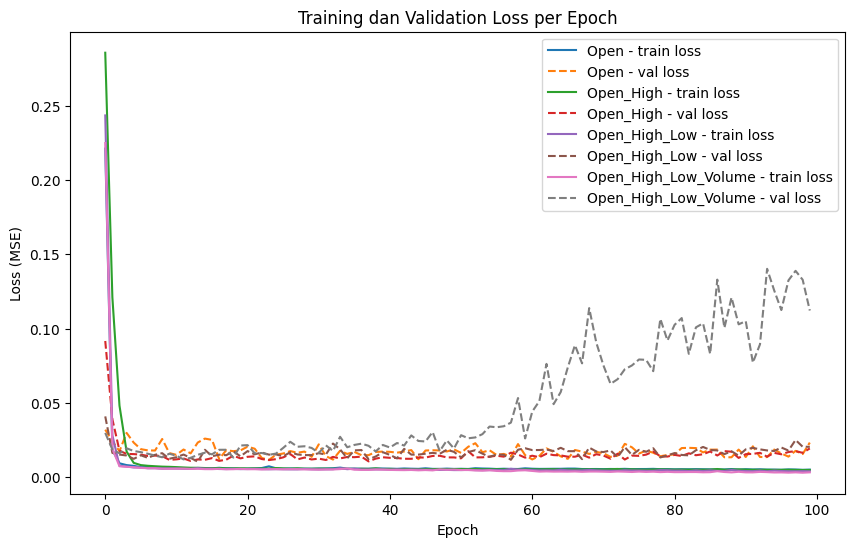

In [15]:
# Visualisasi training loss dan validation loss
plt.figure(figsize=(10,6))
for comb_name, loss_dict in histories.items():
    plt.plot(loss_dict["loss"], label=f"{comb_name} - train loss")
    plt.plot(loss_dict["val_loss"], label=f"{comb_name} - val loss", linestyle='--')
plt.title("Training dan Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

# ADMR

In [10]:
n_steps = 60
ADMR = pd.read_csv('ADMR.csv',parse_dates=['Date'])
ADMR = ADMR.sort_values('Date').reset_index(drop=True)
ADMR



,Date,Close,High,Low,Open,Volume
0,2022-01-03,135,135,135,135,34289600
1,2022-01-04,182,182,182,182,22170900
2,2022-01-05,244,244,220,220,43203600
3,2022-01-06,304,304,304,304,52097500
4,2022-01-07,380,380,380,380,19248600
...,...,...,...,...,...,...
756,2025-02-24,815,830,810,830,15761700
757,2025-02-25,795,825,785,820,21141200
758,2025-02-26,795,820,795,795,19861400
759,2025-02-27,820,845,800,815,23698900


In [11]:
results = []
histories = {}

# Misal data ACES sudah tersedia di variabel ACES
for comb_name, features in input_combinations.items():
    data = ADMR[features].values
    if len(data) < 2 * n_steps:
        continue
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    X, y = [], []
    total_len = len(scaled)
    for i in range(total_len - 2 * n_steps + 1):
        X.append(scaled[i : i + n_steps])
        y.append(scaled[i + n_steps : i + 2 * n_steps, 0])
    X = np.array(X)
    y = np.array(y)
    if len(X) == 0:
        continue
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    model = Sequential()
    model.add(LSTM(50, activation="relu", input_shape=(n_steps, len(features))))
    model.add(Dense(n_steps))
    model.compile(optimizer="adam", loss="mse")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        verbose=0,
        validation_split=0.2
    )
    histories[comb_name] = {
        "loss": history.history['loss'],
        "val_loss": history.history['val_loss']
    }
    y_pred = model.predict(X_test)
    min_close, max_close = scaler.data_min_[0], scaler.data_max_[0]
    y_test_orig = y_test * (max_close - min_close) + min_close
    y_pred_orig = y_pred * (max_close - min_close) + min_close

    # Simpan hasil prediksi dan target untuk cell berikutnya
    globals()[f"y_pred_orig_{comb_name}"] = y_pred_orig
    globals()[f"y_test_orig_{comb_name}"] = y_test_orig

    # Simpan metrik sebelum Kalman Filter
    rmse = np.sqrt(np.mean((y_test_orig - y_pred_orig) ** 2))
    r2 = r2_score(y_test_orig.flatten(), y_pred_orig.flatten())
    results.append([comb_name, rmse, r2])

# Simpan hasil metrik awal ke DataFrame
results_df = pd.DataFrame(results, columns=["kombinasi_input", "RMSE", "R2"])

C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001684143ED40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [12]:
class KalmanFilter:
    def __init__(self, F, B, H, Q, R, x0, P0):
        self.F = F
        self.B = B
        self.H = H
        self.Q = Q
        self.R = R
        self.x = x0
        self.P = P0

    def predict(self, u):
        self.x = self.F @ self.x + self.B @ u
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, z):
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(self.P.shape[0]) - K @ self.H) @ self.P
        return self.x

F = np.array([[1, 1],
              [0, 1]])
B = np.array([[0],
              [0]])
H = np.array([[1, 0]])
Q = np.array([[1, 0],
              [0, 1]])
R = np.array([[100]])

kalman_results = []

for comb_name in input_combinations.keys():
    y_pred_orig = globals()[f"y_pred_orig_{comb_name}"]
    y_test_orig = globals()[f"y_test_orig_{comb_name}"]

    rmse_filtered_list = []
    r2_filtered_list = []

    for i in range(y_pred_orig.shape[0]):
        x0 = np.array([[y_pred_orig[i, 0]], [0]])
        P0 = np.eye(2)
        kf = KalmanFilter(F, B, H, Q, R, x0, P0)

        smoothed_preds = []
        for z in y_pred_orig[i]:
            z = np.array([[z]])
            u = np.array([[0]])
            kf.predict(u)
            x_filtered = kf.update(z)
            smoothed_preds.append(x_filtered[0, 0])
        smoothed_preds = np.array(smoothed_preds)

        rmse_f = np.sqrt(np.mean((y_test_orig[i] - smoothed_preds) ** 2))
        r2_f = r2_score(y_test_orig[i], smoothed_preds)
        rmse_filtered_list.append(rmse_f)
        r2_filtered_list.append(r2_f)

    rmse_filtered = np.mean(rmse_filtered_list)
    r2_filtered = np.mean(r2_filtered_list)
    kalman_results.append([comb_name, rmse_filtered, r2_filtered])


In [13]:
# Simpan hasil metrik awal ke DataFrame
results_df = pd.DataFrame(results, columns=["kombinasi_input", "RMSE", "R2"])
results_df

,kombinasi_input,RMSE,R2
0,Close,136.607823,-0.079880
1,Close_Open,179.807950,-0.870864
2,Close_Open_High,143.027813,-0.183765
3,Close_Open_High_Low,151.283251,-0.324360
4,Close_Open_High_Low_Volume,161.789683,-0.514698


In [14]:
df_kalman_results = pd.DataFrame(kalman_results, columns=["kombinasi_input", "RMSE_Filtered", "R2_Filtered"])
print(df_kalman_results)

              kombinasi_input  RMSE_Filtered  R2_Filtered
0                       Close     126.815828    -1.311671
1                  Close_Open     166.145334    -3.634418
2             Close_Open_High     130.143654    -1.155892
3         Close_Open_High_Low     138.363688    -1.732455
4  Close_Open_High_Low_Volume     153.673692    -4.119742


# ADRO

In [15]:
n_steps = 60
ADRO = pd.read_csv('ADRO.csv',parse_dates=['Date'])
ADRO = ADRO.sort_values('Date').reset_index(drop=True)
ADRO



,Date,Close,High,Low,Open,Volume
0,2015-03-02,284.907837,286.304444,269.545159,270.941767,210962800
1,2015-03-03,283.511169,289.097596,283.511169,286.304383,79843800
2,2015-03-04,275.131561,283.511203,275.131561,282.114596,63253900
3,2015-03-05,280.718048,283.511262,276.528227,280.718048,69880000
4,2015-03-06,275.131561,282.114596,275.131561,280.717989,57587600
...,...,...,...,...,...,...
2468,2025-02-24,2190.000000,2220.000000,2150.000000,2180.000000,25614100
2469,2025-02-25,2100.000000,2190.000000,2080.000000,2180.000000,42874400
2470,2025-02-26,2110.000000,2150.000000,2080.000000,2110.000000,34974000
2471,2025-02-27,2070.000000,2150.000000,2050.000000,2130.000000,42563900


In [16]:
results = []
histories = {}

# Misal data ACES sudah tersedia di variabel ACES
for comb_name, features in input_combinations.items():
    data = ADRO[features].values
    if len(data) < 2 * n_steps:
        continue
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    X, y = [], []
    total_len = len(scaled)
    for i in range(total_len - 2 * n_steps + 1):
        X.append(scaled[i : i + n_steps])
        y.append(scaled[i + n_steps : i + 2 * n_steps, 0])
    X = np.array(X)
    y = np.array(y)
    if len(X) == 0:
        continue
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    model = Sequential()
    model.add(LSTM(50, activation="relu", input_shape=(n_steps, len(features))))
    model.add(Dense(n_steps))
    model.compile(optimizer="adam", loss="mse")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        verbose=0,
        validation_split=0.2
    )
    histories[comb_name] = {
        "loss": history.history['loss'],
        "val_loss": history.history['val_loss']
    }
    y_pred = model.predict(X_test)
    min_close, max_close = scaler.data_min_[0], scaler.data_max_[0]
    y_test_orig = y_test * (max_close - min_close) + min_close
    y_pred_orig = y_pred * (max_close - min_close) + min_close

    # Simpan hasil prediksi dan target untuk cell berikutnya
    globals()[f"y_pred_orig_{comb_name}"] = y_pred_orig
    globals()[f"y_test_orig_{comb_name}"] = y_test_orig

    # Simpan metrik sebelum Kalman Filter
    rmse = np.sqrt(np.mean((y_test_orig - y_pred_orig) ** 2))
    r2 = r2_score(y_test_orig.flatten(), y_pred_orig.flatten())
    results.append([comb_name, rmse, r2])

# Simpan hasil metrik awal ke DataFrame
results_df = pd.DataFrame(results, columns=["kombinasi_input", "RMSE", "R2"])

C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [17]:
class KalmanFilter:
    def __init__(self, F, B, H, Q, R, x0, P0):
        self.F = F
        self.B = B
        self.H = H
        self.Q = Q
        self.R = R
        self.x = x0
        self.P = P0

    def predict(self, u):
        self.x = self.F @ self.x + self.B @ u
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, z):
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(self.P.shape[0]) - K @ self.H) @ self.P
        return self.x

F = np.array([[1, 1],
              [0, 1]])
B = np.array([[0],
              [0]])
H = np.array([[1, 0]])
Q = np.array([[1, 0],
              [0, 1]])
R = np.array([[100]])

kalman_results = []

for comb_name in input_combinations.keys():
    y_pred_orig = globals()[f"y_pred_orig_{comb_name}"]
    y_test_orig = globals()[f"y_test_orig_{comb_name}"]

    rmse_filtered_list = []
    r2_filtered_list = []

    for i in range(y_pred_orig.shape[0]):
        x0 = np.array([[y_pred_orig[i, 0]], [0]])
        P0 = np.eye(2)
        kf = KalmanFilter(F, B, H, Q, R, x0, P0)

        smoothed_preds = []
        for z in y_pred_orig[i]:
            z = np.array([[z]])
            u = np.array([[0]])
            kf.predict(u)
            x_filtered = kf.update(z)
            smoothed_preds.append(x_filtered[0, 0])
        smoothed_preds = np.array(smoothed_preds)

        rmse_f = np.sqrt(np.mean((y_test_orig[i] - smoothed_preds) ** 2))
        r2_f = r2_score(y_test_orig[i], smoothed_preds)
        rmse_filtered_list.append(rmse_f)
        r2_filtered_list.append(r2_f)

    rmse_filtered = np.mean(rmse_filtered_list)
    r2_filtered = np.mean(r2_filtered_list)
    kalman_results.append([comb_name, rmse_filtered, r2_filtered])


In [18]:
# Simpan hasil metrik awal ke DataFrame
results_df = pd.DataFrame(results, columns=["kombinasi_input", "RMSE", "R2"])
results_df

,kombinasi_input,RMSE,R2
0,Close,4.935094e+02,-4.698394e-01
1,Close_Open,4.726610e+02,-3.482754e-01
2,Close_Open_High,4.538502e+02,-2.430943e-01
3,Close_Open_High_Low,4.923928e+02,-4.631961e-01
4,Close_Open_High_Low_Volume,1.649688e+10,-1.642415e+15


In [19]:
df_kalman_results = pd.DataFrame(kalman_results, columns=["kombinasi_input", "RMSE_Filtered", "R2_Filtered"])
print(df_kalman_results)

              kombinasi_input  RMSE_Filtered   R2_Filtered
0                       Close   4.543626e+02 -2.772030e+01
1                  Close_Open   4.343923e+02 -2.546045e+01
2             Close_Open_High   4.168275e+02 -2.319280e+01
3         Close_Open_High_Low   4.512254e+02 -2.736934e+01
4  Close_Open_High_Low_Volume   3.596039e+09 -5.886800e+15


# AKRA

In [20]:
n_steps = 60
AKRA = pd.read_csv('AKRA.csv',parse_dates=['Date'])
AKRA = AKRA.sort_values('Date').reset_index(drop=True)
AKRA



,Date,Close,High,Low,Open,Volume
0,2015-03-02,654.731506,655.389528,640.913052,640.913052,40472000
1,2015-03-03,656.705505,664.601764,656.705505,656.705505,55335500
2,2015-03-04,664.601868,667.891976,651.441435,656.705608,42905500
3,2015-03-05,667.891907,667.891907,658.021583,667.891907,40835000
4,2015-03-06,654.731506,674.472155,654.731506,671.182047,24751500
...,...,...,...,...,...,...
2469,2025-02-24,1215.000000,1235.000000,1215.000000,1235.000000,6739900
2470,2025-02-25,1200.000000,1225.000000,1195.000000,1220.000000,6982800
2471,2025-02-26,1205.000000,1220.000000,1200.000000,1200.000000,6508500
2472,2025-02-27,1310.000000,1330.000000,1220.000000,1220.000000,106148000


In [21]:
results = []
histories = {}

# Misal data ACES sudah tersedia di variabel ACES
for comb_name, features in input_combinations.items():
    data = AKRA[features].values
    if len(data) < 2 * n_steps:
        continue
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    X, y = [], []
    total_len = len(scaled)
    for i in range(total_len - 2 * n_steps + 1):
        X.append(scaled[i : i + n_steps])
        y.append(scaled[i + n_steps : i + 2 * n_steps, 0])
    X = np.array(X)
    y = np.array(y)
    if len(X) == 0:
        continue
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    model = Sequential()
    model.add(LSTM(50, activation="relu", input_shape=(n_steps, len(features))))
    model.add(Dense(n_steps))
    model.compile(optimizer="adam", loss="mse")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        verbose=0,
        validation_split=0.2
    )
    histories[comb_name] = {
        "loss": history.history['loss'],
        "val_loss": history.history['val_loss']
    }
    y_pred = model.predict(X_test)
    min_close, max_close = scaler.data_min_[0], scaler.data_max_[0]
    y_test_orig = y_test * (max_close - min_close) + min_close
    y_pred_orig = y_pred * (max_close - min_close) + min_close

    # Simpan hasil prediksi dan target untuk cell berikutnya
    globals()[f"y_pred_orig_{comb_name}"] = y_pred_orig
    globals()[f"y_test_orig_{comb_name}"] = y_test_orig

    # Simpan metrik sebelum Kalman Filter
    rmse = np.sqrt(np.mean((y_test_orig - y_pred_orig) ** 2))
    r2 = r2_score(y_test_orig.flatten(), y_pred_orig.flatten())
    results.append([comb_name, rmse, r2])

# Simpan hasil metrik awal ke DataFrame
results_df = pd.DataFrame(results, columns=["kombinasi_input", "RMSE", "R2"])

C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [22]:
class KalmanFilter:
    def __init__(self, F, B, H, Q, R, x0, P0):
        self.F = F
        self.B = B
        self.H = H
        self.Q = Q
        self.R = R
        self.x = x0
        self.P = P0

    def predict(self, u):
        self.x = self.F @ self.x + self.B @ u
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, z):
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(self.P.shape[0]) - K @ self.H) @ self.P
        return self.x

F = np.array([[1, 1],
              [0, 1]])
B = np.array([[0],
              [0]])
H = np.array([[1, 0]])
Q = np.array([[1, 0],
              [0, 1]])
R = np.array([[100]])

kalman_results = []

for comb_name in input_combinations.keys():
    y_pred_orig = globals()[f"y_pred_orig_{comb_name}"]
    y_test_orig = globals()[f"y_test_orig_{comb_name}"]

    rmse_filtered_list = []
    r2_filtered_list = []

    for i in range(y_pred_orig.shape[0]):
        x0 = np.array([[y_pred_orig[i, 0]], [0]])
        P0 = np.eye(2)
        kf = KalmanFilter(F, B, H, Q, R, x0, P0)

        smoothed_preds = []
        for z in y_pred_orig[i]:
            z = np.array([[z]])
            u = np.array([[0]])
            kf.predict(u)
            x_filtered = kf.update(z)
            smoothed_preds.append(x_filtered[0, 0])
        smoothed_preds = np.array(smoothed_preds)

        rmse_f = np.sqrt(np.mean((y_test_orig[i] - smoothed_preds) ** 2))
        r2_f = r2_score(y_test_orig[i], smoothed_preds)
        rmse_filtered_list.append(rmse_f)
        r2_filtered_list.append(r2_f)

    rmse_filtered = np.mean(rmse_filtered_list)
    r2_filtered = np.mean(r2_filtered_list)
    kalman_results.append([comb_name, rmse_filtered, r2_filtered])


In [23]:
# Simpan hasil metrik awal ke DataFrame
results_df = pd.DataFrame(results, columns=["kombinasi_input", "RMSE", "R2"])
results_df

,kombinasi_input,RMSE,R2
0,Close,5.191022e+02,-1.115907e+01
1,Close_Open,5.146625e+02,-1.095198e+01
2,Close_Open_High,5.941992e+04,-1.593148e+05
3,Close_Open_High_Low,5.704603e+02,-1.368404e+01
4,Close_Open_High_Low_Volume,1.029341e+06,-4.780940e+07


In [24]:
df_kalman_results = pd.DataFrame(kalman_results, columns=["kombinasi_input", "RMSE_Filtered", "R2_Filtered"])
print(df_kalman_results)

              kombinasi_input  RMSE_Filtered   R2_Filtered
0                       Close     495.609279 -8.740171e+01
1                  Close_Open     474.722290 -8.561363e+01
2             Close_Open_High   17934.149100 -1.818205e+06
3         Close_Open_High_Low     541.388943 -1.074529e+02
4  Close_Open_High_Low_Volume  395247.552729 -5.812204e+08


# AMMN

In [25]:
n_steps = 60
AMMN = pd.read_csv('AMMN.csv',parse_dates=['Date'])
AMMN = AMMN.sort_values('Date').reset_index(drop=True)
AMMN



,Date,Close,High,Low,Open,Volume
0,2023-07-07,1755,1820,1700,1745,411565100
1,2023-07-10,1750,1765,1745,1755,59010700
2,2023-07-11,1750,1760,1750,1750,34028600
3,2023-07-12,1765,1765,1750,1750,27860100
4,2023-07-13,1760,1765,1750,1765,41745700
...,...,...,...,...,...,...
392,2025-02-24,6900,7275,6800,7275,11327600
393,2025-02-25,6575,7050,6575,6925,12744000
394,2025-02-26,6525,6775,6400,6600,12009100
395,2025-02-27,6900,6900,6500,6550,17725800


In [26]:
results = []
histories = {}

# Misal data ACES sudah tersedia di variabel ACES
for comb_name, features in input_combinations.items():
    data = AMMN[features].values
    if len(data) < 2 * n_steps:
        continue
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    X, y = [], []
    total_len = len(scaled)
    for i in range(total_len - 2 * n_steps + 1):
        X.append(scaled[i : i + n_steps])
        y.append(scaled[i + n_steps : i + 2 * n_steps, 0])
    X = np.array(X)
    y = np.array(y)
    if len(X) == 0:
        continue
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    model = Sequential()
    model.add(LSTM(50, activation="relu", input_shape=(n_steps, len(features))))
    model.add(Dense(n_steps))
    model.compile(optimizer="adam", loss="mse")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        verbose=0,
        validation_split=0.2
    )
    histories[comb_name] = {
        "loss": history.history['loss'],
        "val_loss": history.history['val_loss']
    }
    y_pred = model.predict(X_test)
    min_close, max_close = scaler.data_min_[0], scaler.data_max_[0]
    y_test_orig = y_test * (max_close - min_close) + min_close
    y_pred_orig = y_pred * (max_close - min_close) + min_close

    # Simpan hasil prediksi dan target untuk cell berikutnya
    globals()[f"y_pred_orig_{comb_name}"] = y_pred_orig
    globals()[f"y_test_orig_{comb_name}"] = y_test_orig

    # Simpan metrik sebelum Kalman Filter
    rmse = np.sqrt(np.mean((y_test_orig - y_pred_orig) ** 2))
    r2 = r2_score(y_test_orig.flatten(), y_pred_orig.flatten())
    results.append([comb_name, rmse, r2])

# Simpan hasil metrik awal ke DataFrame
results_df = pd.DataFrame(results, columns=["kombinasi_input", "RMSE", "R2"])

C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


C:\Users\ASUS.LAPTOP-A525HU97\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


In [27]:
class KalmanFilter:
    def __init__(self, F, B, H, Q, R, x0, P0):
        self.F = F
        self.B = B
        self.H = H
        self.Q = Q
        self.R = R
        self.x = x0
        self.P = P0

    def predict(self, u):
        self.x = self.F @ self.x + self.B @ u
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, z):
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(self.P.shape[0]) - K @ self.H) @ self.P
        return self.x

F = np.array([[1, 1],
              [0, 1]])
B = np.array([[0],
              [0]])
H = np.array([[1, 0]])
Q = np.array([[1, 0],
              [0, 1]])
R = np.array([[100]])

kalman_results = []

for comb_name in input_combinations.keys():
    y_pred_orig = globals()[f"y_pred_orig_{comb_name}"]
    y_test_orig = globals()[f"y_test_orig_{comb_name}"]

    rmse_filtered_list = []
    r2_filtered_list = []

    for i in range(y_pred_orig.shape[0]):
        x0 = np.array([[y_pred_orig[i, 0]], [0]])
        P0 = np.eye(2)
        kf = KalmanFilter(F, B, H, Q, R, x0, P0)

        smoothed_preds = []
        for z in y_pred_orig[i]:
            z = np.array([[z]])
            u = np.array([[0]])
            kf.predict(u)
            x_filtered = kf.update(z)
            smoothed_preds.append(x_filtered[0, 0])
        smoothed_preds = np.array(smoothed_preds)

        rmse_f = np.sqrt(np.mean((y_test_orig[i] - smoothed_preds) ** 2))
        r2_f = r2_score(y_test_orig[i], smoothed_preds)
        rmse_filtered_list.append(rmse_f)
        r2_filtered_list.append(r2_f)

    rmse_filtered = np.mean(rmse_filtered_list)
    r2_filtered = np.mean(r2_filtered_list)
    kalman_results.append([comb_name, rmse_filtered, r2_filtered])


In [28]:
# Simpan hasil metrik awal ke DataFrame
results_df = pd.DataFrame(results, columns=["kombinasi_input", "RMSE", "R2"])
results_df

,kombinasi_input,RMSE,R2
0,Close,2050.303867,-7.812947
1,Close_Open,2249.799187,-9.611389
2,Close_Open_High,1947.359334,-6.950179
3,Close_Open_High_Low,1962.884177,-7.077446
4,Close_Open_High_Low_Volume,2355.624569,-10.633138


In [29]:
df_kalman_results = pd.DataFrame(kalman_results, columns=["kombinasi_input", "RMSE_Filtered", "R2_Filtered"])
print(df_kalman_results)

              kombinasi_input  RMSE_Filtered  R2_Filtered
0                       Close    2013.224921   -17.666127
1                  Close_Open    2222.845261   -21.191480
2             Close_Open_High    1910.290679   -15.392874
3         Close_Open_High_Low    1933.266567   -15.671025
4  Close_Open_High_Low_Volume    2311.568299   -22.485277
